In [28]:
# Predict volume of receipts that will be uploaded per day for the next 4 weeks.
# Please use the provided dataset and use the uploadedTime field associated to each receipt.
#
# Long Short-Term Memory (LSTM) networks

In [29]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [30]:
pd.options.display.max_colwidth = 10000

In [31]:
# read provided dataset
df = pd.read_csv("../receipt_data.csv")
df.head(1)

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage
0,NaN,GBP,2019-06-15 17:00:57,2019-06-14 18:20:00,REVIEWED,2019-06-14 22:11:40,0.7,NaN,2019-06-15 17:00:57,NaN,NaN,NaN,Selfridges,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Selfridges"",""validatedEstablishment"":false,""date"":""2019-06-14 18:20:00"",""total"":30.000,""url"":""www.selfridges.com"",""phoneNumber"":""8569 4004156"",""paymentMethod"":""VISA"",""address"":""400 Oxford Street London W1A 1AB"",""validatedTotal"":false,""subTotal"":30.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""FULTON BROLLYMA41568569 400415685692"",""unit"":"""",""price"":0.000,""descClean"":""You 193 were served by : Ines FULTON BROLLYMA 400415685692"",""lineTotal"":18.000,""productCode"":""41568569""},{""qty"":0,""desc"":""JJ DOT HYDR - TRA 82401412"",""unit"":"""",""price"":0.000,""descClean"":""JJ DOT HYDR - TRA"",""lineTotal"":12.000,""productCode"":""82401412""}],""summaryItems"":[{""qty"":2,""desc"":""Total 2 Items"",""unit"":"""",""price"":0.000,""descClean"":""Total Items"",""lineTotal"":30.000,""productCode"":""""},{""qty"":0,""desc"":""Visa"",""unit"":"""",""price"":0.000,""descClean"":""Visa"",""lineTotal"":30.000,""productCode"":""""},{""qty"":14,""desc"":""009999 Date 14 / 06 / 19"",""unit"":"""",""price"":0.000,""descClean"":""Date / 06 / 19"",""lineTotal"":18.200,""productCode"":""009999""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/5955cc32-894b-4dbd-8c1f-f54fbd95d8e8


In [32]:
df['uploadedTime'].head(5)

0    2019-06-14 22:11:40
1    2019-06-19 20:01:34
2    2019-06-18 17:52:03
3    2019-06-24 12:42:05
4    2019-06-16 15:25:05
Name: uploadedTime, dtype: object

In [33]:
empty_dates = df[df.uploadedTime.apply(lambda x: not isinstance(x, str))]
empty_dates

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage


In [34]:
# transform uploadedTime to datetime and sort
df['uploadedTime'] = pd.to_datetime(df.uploadedTime)
df.sort_values('uploadedTime')

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage
5420,NaN,GBP,2019-04-17 09:57:51,2019-04-17 09:12:00,REVIEWED,2019-04-17 09:10:37,0.80,NaN,NaN,NaN,NaN,NaN,Boots,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Lenongestoomos 18 ron agrisloxo"",""validatedEstablishment"":false,""date"":""2019-04-17 09:12:00"",""total"":2.190,""url"":"""",""phoneNumber"":""194 3487 2062"",""paymentMethod"":""VISA"",""address"":"""",""validatedTotal"":false,""subTotal"":0.000,""validatedSubTotal"":false,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.0,""totalConfidence"":0.8,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[""Lenongestoomos 18 ron agrisloxo"",""1990 The own"",""e"",""10.16 ocort"",""Coralbam berujen"",""Boots UK Limited the son obert"",""MANCHESTER T1 LANDSIDE - 2062 ore"",""(0161) 4372099 Bobbs bestaan"",""17/04/2019"",""€2.19"",""194 3487 2062 133"",""""],""lineItems"":[{""qty"":17,""desc"":""17 / 04 / 2019"",""unit"":"""",""price"":0.000,""descClean"":""ore ( 0161 ) Bobbs bestaan / 04 / 2019"",""lineTotal"":9.120,""productCode"":""4372099""},{""qty"":12,""desc"":""Bp Wound Cins Wps"",""unit"":"""",""price"":0.000,""descClean"":""Served by : Connor : espoocarr.M TAV bere £ Bp Wound Cins Wps"",""lineTotal"":2.190,""productCode"":""""}],""summaryItems"":[{""qty"":0,""desc"":""TOTAL TO PAY"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL TO PAY"",""lineTotal"":2.190,""productCode"":""""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/c300f1fe-b2b2-4e53-986d-1f2557626793
6784,NaN,GBP,2019-04-17 11:37:56,2019-04-12 13:42:00,REVIEWED,2019-04-17 11:37:23,0.99,NaN,NaN,NaN,NaN,NaN,Boots,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Boots UK Limited"",""validatedEstablishment"":false,""date"":""2019-12-04 00:00:00"",""total"":6.000,""url"":"""",""phoneNumber"":"""",""paymentMethod"":"""",""address"":"""",""validatedTotal"":false,""subTotal"":0.000,""validatedSubTotal"":false,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.0,""totalConfidence"":0.99,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[""Boots UK Limited"",""lets ieel good"",""ADVANTAGE CARD STATENENT"",""Points Received"",""Points to Spend in Store"",""5704"",""""],""lineItems"":[],""summaryItems"":[{""qty"":0,""desc"":""TOTAL TO PAY"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL TO PAY"",""lineTotal"":6.000,""productCode"":""""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/2f5b7edb-59bb-4224-8cd7-01f07ac4662e
1776,NaN,GBP,2019-04-17 13:32:52,2019-08-04 17:36:00,REVIEWED,2019-04-17 13:28:39,0.70,NaN,NaN,NaN,NaN,NaN,Debenhams,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""DEBENHAMS"",""validatedEstablishment"":false,""date"":""2019-04-08 17:36:00"",""total"":156.000,""url"":""howdidwedotoday.debenhams.com"",""phoneNumber"":""0344 561 6161"",""paymentMethod"":""Mastercard"",""address"":"", TEL NO 0344 561 6161"",""validatedTotal"":false,""subTotal"":156.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[""THANK YOU FOR SHOPPING AT"",""DEBENHAMS"",""BIRMI

In [35]:
# floor uploadedTime to day and aggregate count
daily_receipts = (df.uploadedTime
       .dt.floor('d')
       .value_counts()
       .rename_axis('uploadedDate')
       .reset_index(name='counts'))
daily_receipts.head(5)

,uploadedDate,counts
0,2019-06-29,278
1,2019-06-30,274
2,2019-06-22,243
3,2019-06-21,231
4,2019-06-26,229


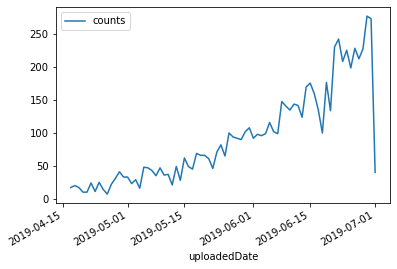

In [36]:
daily_receipts.plot(x='uploadedDate', y='counts', kind="line")
plt.show()

In [37]:
daily_receipts.counts = daily_receipts.counts.astype('float32')
daily_receipts = daily_receipts.sort_values(by=['counts'])
daily_receipts.head(2)

,uploadedDate,counts
75,2019-04-26,7.0
74,2019-04-21,10.0


In [38]:
dataset = daily_receipts.values

In [39]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(daily_receipts.filter(['counts']))

In [40]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

50 26


In [41]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [42]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [43]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [44]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
48/48 - 0s - loss: 0.0135
Epoch 2/100
48/48 - 0s - loss: 0.0065
Epoch 3/100
48/48 - 0s - loss: 0.0053
Epoch 4/100
48/48 - 0s - loss: 0.0048
Epoch 5/100
48/48 - 0s - loss: 0.0045
Epoch 6/100
48/48 - 0s - loss: 0.0043
Epoch 7/100
48/48 - 0s - loss: 0.0038
Epoch 8/100
48/48 - 0s - loss: 0.0034
Epoch 9/100
48/48 - 0s - loss: 0.0031
Epoch 10/100
48/48 - 0s - loss: 0.0028
Epoch 11/100
48/48 - 0s - loss: 0.0025
Epoch 12/100
48/48 - 0s - loss: 0.0021
Epoch 13/100
48/48 - 0s - loss: 0.0019
Epoch 14/100
48/48 - 0s - loss: 0.0016
Epoch 15/100
48/48 - 0s - loss: 0.0014
Epoch 16/100
48/48 - 0s - loss: 0.0011
Epoch 17/100
48/48 - 0s - loss: 9.4173e-04
Epoch 18/100
48/48 - 0s - loss: 7.7899e-04
Epoch 19/100
48/48 - 0s - loss: 6.3298e-04
Epoch 20/100
48/48 - 0s - loss: 5.1369e-04
Epoch 21/100
48/48 - 0s - loss: 4.1308e-04
Epoch 22/100
48/48 - 0s - loss: 3.2139e-04
Epoch 23/100
48/48 - 0s - loss: 2.5889e-04
Epoch 24/100
48/48 - 0s - loss: 2.1058e-04
Epoch 25/100
48/48 - 0s - loss: 1.7313e-0

In [45]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.44 RMSE
Test Score: 13.82 RMSE


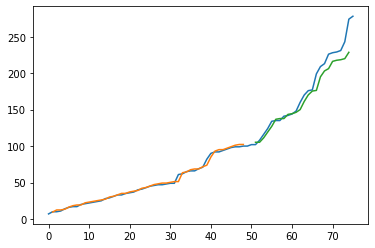

In [46]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()